<a href="https://colab.research.google.com/github/abhisheky2j/Image-Classification-on-CIFAR10/blob/master/Image_Generation_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the Data

In [2]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"depplenny","key":"c218b6c8a3963c58f9e99de7a89ec338"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-luyc75vh
  Running command git clone --filter=blob:none --quiet https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-luyc75vh
  Resolved https://github.com/Kaggle/kaggle-api.git to commit 139fdd7ca57b3f93da8318fb68b97823a74a34df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!kaggle datasets list -s animefacedataset

ref                               title                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------  ------------------  ----------  --------------------------  -------------  ---------  ---------------  
manishamannu/animefacedataset     animefacedataset     413825766  2020-09-01 06:56:08.460000             36          1  0.125            
vitorsimplicio2/animefacedataset  animefacedataset          4066  2025-02-28 00:16:20.527000              0          0  0.25             
splcher/animefacedataset          Anime Face Dataset   413825766  2019-10-13 16:33:20.520000          37380        424  0.9375           


In [4]:
!kaggle datasets download -d splcher/animefacedataset

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0


In [5]:
!unzip animefacedataset.zip -d animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62764_2019.jpg  
  inflating: animefacedataset/images/62765_2019.jpg  
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/im

In [6]:
DATA_DIR = '/content/animefacedataset'

In [7]:
import os

print(os.listdir(DATA_DIR))

['images']


In [8]:
print(os.listdir(DATA_DIR+'/images')[:10])

['36665_2012.jpg', '6348_2003.jpg', '39630_2012.jpg', '51107_2015.jpg', '38243_2012.jpg', '5652_2003.jpg', '1764_2001.jpg', '42105_2013.jpg', '56255_2017.jpg', '17261_2007.jpg']


In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [10]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [11]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

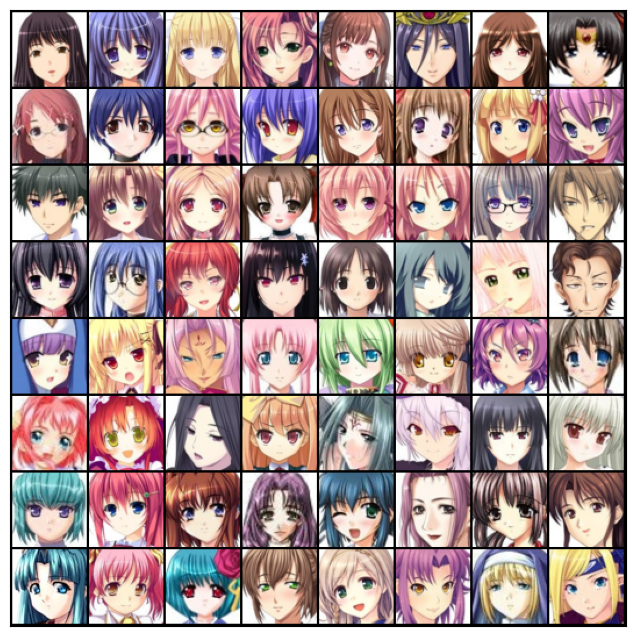

In [15]:
show_batch(train_dl)

In [33]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [34]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [35]:
lr = 0.0002
epochs = 25

In [36]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 6.2588, loss_d: 0.3438, real_score: 0.7823, fake_score: 0.0222
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.5874, loss_d: 0.5305, real_score: 0.8786, fake_score: 0.2912
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 7.1182, loss_d: 0.0819, real_score: 0.9572, fake_score: 0.0332
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.2521, loss_d: 1.2221, real_score: 0.4271, fake_score: 0.0008
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.8148, loss_d: 0.2051, real_score: 0.9942, fake_score: 0.1608
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.2089, loss_d: 0.1199, real_score: 0.9345, fake_score: 0.0428
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 8.7408, loss_d: 0.4323, real_score: 0.9753, fake_score: 0.2863
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 7.3892, loss_d: 0.3046, real_score: 0.9589, fake_score: 0.2011
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.4685, loss_d: 0.1917, real_score: 0.9623, fake_score: 0.1316
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.3320, loss_d: 0.2308, real_score: 0.9804, fake_score: 0.1717
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.4320, loss_d: 0.2998, real_score: 0.9373, fake_score: 0.1798
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.9952, loss_d: 0.1746, real_score: 0.8681, fake_score: 0.0111
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.4767, loss_d: 0.2510, real_score: 0.9433, fake_score: 0.1522
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.2560, loss_d: 0.2132, real_score: 0.9322, fake_score: 0.1069
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.7957, loss_d: 0.2020, real_score: 0.8736, fake_score: 0.0400
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.4338, loss_d: 0.1018, real_score: 0.9813, fake_score: 0.0727
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.1226, loss_d: 0.2575, real_score: 0.9297, fake_score: 0.1499
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.9818, loss_d: 0.1104, real_score: 0.9598, fake_score: 0.0618
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 1.8533, loss_d: 0.4555, real_score: 0.6991, fake_score: 0.0045
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.1840, loss_d: 0.0769, real_score: 0.9640, fake_score: 0.0352
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 2.7373, loss_d: 0.2501, real_score: 0.9045, fake_score: 0.1156
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.4672, loss_d: 0.1065, real_score: 0.9888, fake_score: 0.0851
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.7579, loss_d: 0.1084, real_score: 0.9705, fake_score: 0.0695
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 1.0412, loss_d: 0.3774, real_score: 0.7431, fake_score: 0.0039
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 8.2331, loss_d: 0.5884, real_score: 0.9987, fake_score: 0.3756
Saving generated-images-0025.png


In [37]:
losses_g, losses_d, real_scores, fake_scores = history

In [38]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [39]:
from IPython.display import Image

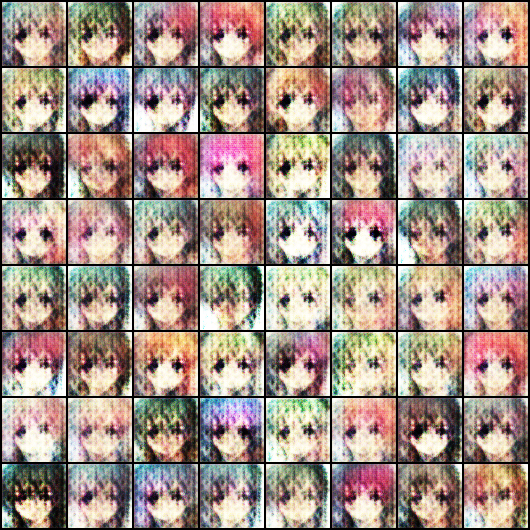

In [40]:
Image('./generated/generated-images-0001.png')

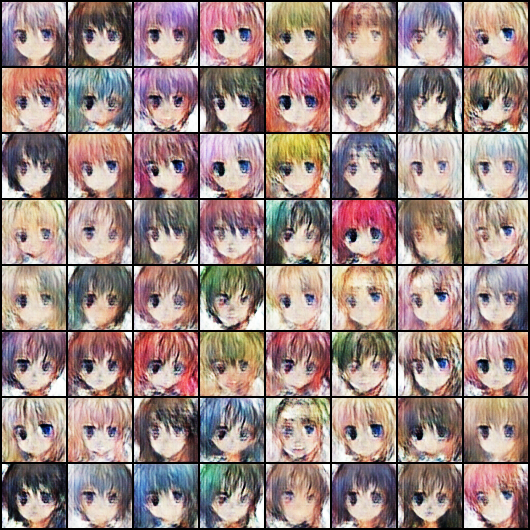

In [41]:
Image('./generated/generated-images-0005.png')

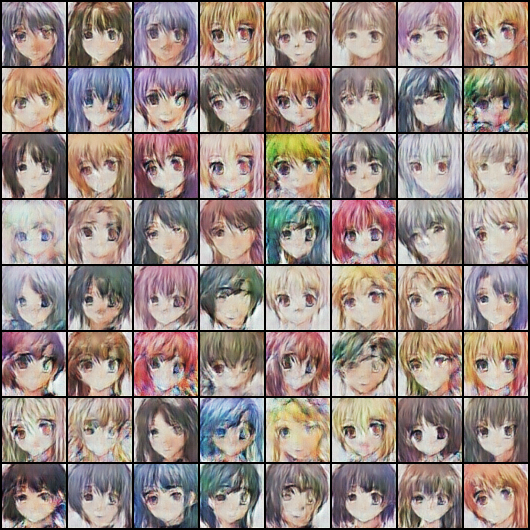

In [42]:
Image('./generated/generated-images-0010.png')

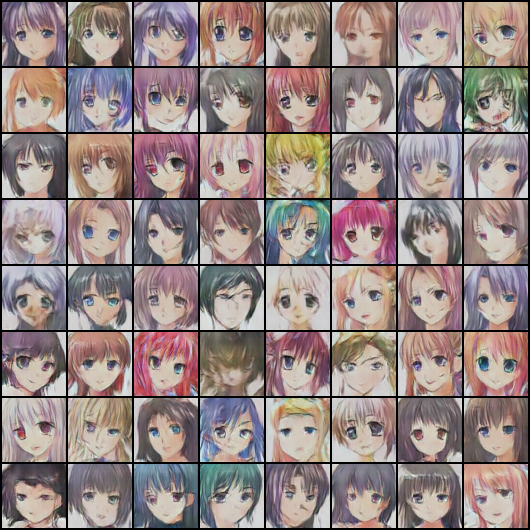

In [43]:
Image('./generated/generated-images-0020.png')

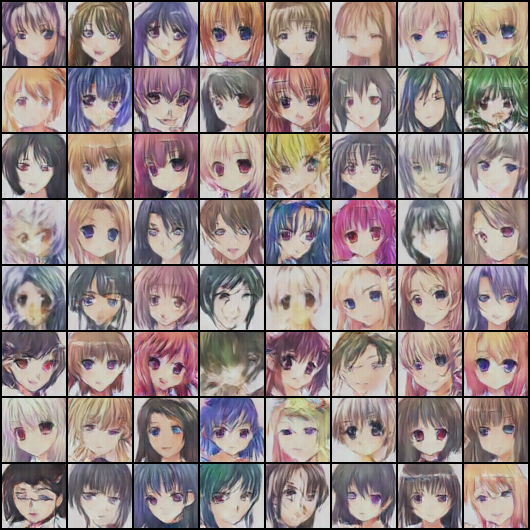

In [44]:
Image('./generated/generated-images-0025.png')

In [45]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

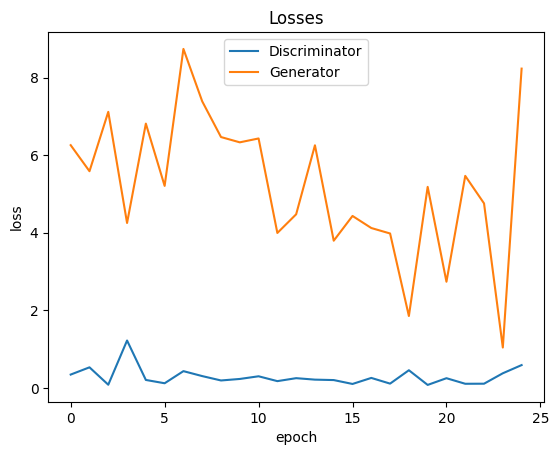

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

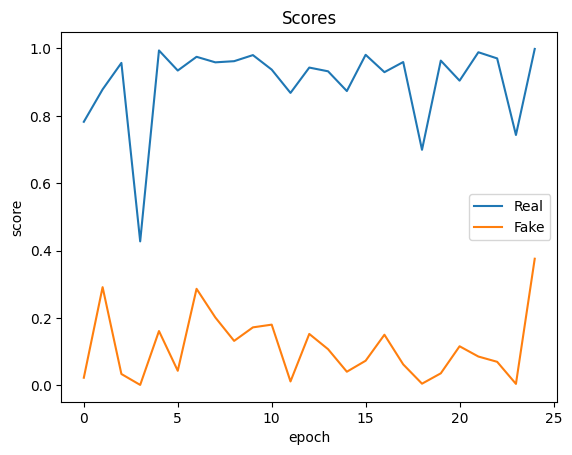

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');